In [1]:
from sSMC import MarginalDistr
import numpy as np

In [3]:
md = MarginalDistr(0.1, 0.1, 1.0, 2.0)
init_cond = np.array([1.0, 0.0, 0.0])
p = md.CalcProb(1.0, init_cond)
print(p)
print(1-sum(p))

[0.30553514 0.00328325 0.10412313]
0.5870584828723702


In [1]:
class lineage:
    def __init__(self, a, b, p):
        #a and b indicates ancestral material (1) or non-ancestral (0)
        self.a = a
        self.b = b
        self.p = p#0 or 1 population

In [2]:
l = lineage(1,0,0)

isinstance(l, lineage)

True

In [3]:
l = [ '100', '010', '000', '011' ]
l.sort()
l

['000', '010', '011', '100']

In [17]:
import numpy as np
from scipy import linalg
from scipy.integrate import odeint
from numpy import dot
import matplotlib.pyplot as plt

class lineage:
    def __init__(self, a, b, p):
        #a and b indicates ancestral material (1) or non-ancestral (0)
        self.a = a
        self.b = b
        self.p = p#0 or 1 population

    def __str__(self):
        return str(self.a)+str(self.b)+str(self.p)

class state:
    def __init__(self, lng):
        self.lng = lng
        self.l = len(lng)
        self.name()

    def name(self):
        lng_s = []
        for l in self.lng:
            lng_s.append( str(l.a) + str(l.b) + str(l.p) )
        lng_s.sort()
        self.n = ','.join(lng_s)

class param:
    def __init__(self):
        self.rho = 1.

numStates =[
#    [ [1,1,0] ],
#    [ [1,1,1] ],

    [ [1,1,0],[1,1,0] ],
    [ [1,1,0],[1,1,1] ],
    [ [1,1,1],[1,1,1] ],

    [ [1,0,0],[1,1,0] ],
    [ [1,0,0],[1,1,1] ],
    [ [1,0,1],[1,1,0] ],
    [ [1,0,1],[1,1,1] ],

    [ [0,1,0],[1,1,0] ],
    [ [0,1,0],[1,1,1] ],
    [ [0,1,1],[1,1,0] ],
    [ [0,1,1],[1,1,1] ],

    [ [0,1,0],[1,0,0] ],
    [ [0,1,0],[1,0,1] ],
    [ [0,1,1],[1,0,0] ],
    [ [0,1,1],[1,0,1] ],

    [ [1,0,0],[0,1,0],[1,1,0] ],
    [ [1,0,0],[0,1,0],[1,1,1] ],
    [ [1,0,0],[0,1,1],[1,1,0] ],
    [ [1,0,0],[0,1,1],[1,1,1] ],
    [ [1,0,1],[0,1,0],[1,1,0] ],
    [ [1,0,1],[0,1,0],[1,1,1] ],
    [ [1,0,1],[0,1,1],[1,1,0] ],
    [ [1,0,1],[0,1,1],[1,1,1] ],

    [ [1,0,0],[0,1,0],[0,1,0] ],
    [ [1,0,0],[0,1,0],[0,1,1] ],
    [ [1,0,0],[0,1,1],[0,1,1] ],
    [ [1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,1],[0,1,1],[0,1,1] ],

    [ [1,0,0],[1,0,0],[0,1,0] ],
    [ [1,0,0],[1,0,0],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,0] ],
    [ [1,0,0],[1,0,1],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,0] ],
    [ [1,0,1],[1,0,1],[0,1,1] ],

    [ [1,0,0],[1,0,0],[0,1,0],[0,1,0] ],
    [ [1,0,0],[1,0,0],[0,1,0],[0,1,1] ],
    [ [1,0,0],[1,0,0],[0,1,1],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,0],[1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,1],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,1],[1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,1],[0,1,1] ]
]

Mdim = len(numStates)

states = []
stateToNum = {}
i = 0
for st in numStates:
    lng = []
    for l in st:
        lng.append( lineage(l[0], l[1], l[2]) )
    states.append( state(lng) )
    stateToNum[states[-1].n] = i
    i += 1

def Eq(P, t):
    return dot(dot(M,params(t)),P)

def Coal(st, i, k):
    if i > st.l or k > st.l:
        print("Wrong lineage index.")
    if st.lng[i].p != st.lng[k].p:
        print("Coalescence is impossible.")
    newState = [st.lng[j] for j in range(st.l) if i != j and k != j]
    newState.append(lineage(st.lng[i].a | st.lng[k].a, st.lng[i].b | st.lng[k].b, st.lng[i].p))
    newState = state(newState)
    if newState.l > 1:
        return stateToNum[newState.n]
    else:
        return -1

#Matrix entry [rho, l1, l2, m1, m2]

def Matrix():
    trRate = np.zeros( (Mdim, Mdim, 5), int )
    for s in range(Mdim):
        st = states[s]
        for i in range(st.l):
            #recombination
            if st.lng[i].a & st.lng[i].b:
                newState = [st.lng[j] for j in range(st.l) if i != j]
                newState.append(lineage(1,0,st.lng[i].p))
                newState.append(lineage(0,1,st.lng[i].p))
                newState = state(newState)
                trRate[s,stateToNum[newState.n],0] += 1
                trRate[s,s,0] -= 1
            #coalescence
            for k in range(i+1,st.l):
                if st.lng[i].p == st.lng[k].p:
                    newState_id = Coal(st, i, k)
                    if newState_id != -1:
                        trRate[s, newState_id, st.lng[i].p+1 ] += 1
                    trRate[s, s, st.lng[i].p+1 ] -= 1
            #migration
            newState = [st.lng[j] for j in range(st.l) if i != j]
            newState.append( lineage(st.lng[i].a,st.lng[i].b,(st.lng[i].p+1)%2) )
            newState = state(newState)
            trRate[s, stateToNum[newState.n], st.lng[i].p+3 ] += 1
            trRate[s, s, st.lng[i].p+3 ] -= 1
    return( np.transpose(trRate, (1,0,2)) )

def FirstCoal(locus, popID):
    statesProb = np.zeros( (Mdim, Mdim) )
    for s in range(Mdim):
        st = states[s]
        count_a, count_b = 0, 0
        ind = []
        for i, l in enumerate(st.lng):
            if locus == 'a':
                if l.a == 1 and l.p == popID:
                    ind.append(i)
                    count_a += 1
                count_b += l.b
            if locus == 'b':
                if l.b == 1 and l.p == popID:
                    ind.append(i)
                    count_b += 1
                count_a += l.a
        if st.l > 2 and count_a == 2 and count_b == 2:
            newState_id = Coal(st, ind[0], ind[1])
            statesProb[newState_id, s] += 1
    return statesProb

def SecondCoal(locus, popID):
    statesProb = np.zeros( (Mdim, Mdim) )
    for s in range(Mdim):
        st = states[s]
        count_a, count_b = 0, 0
        ind = []
        for i, l in enumerate(st.lng):
            if locus == 'a':
                if l.a == 1 and l.p == popID:
                    ind.append(i)
                    count_a += 1
                count_b += l.b
            if locus == 'b':
                if l.b == 1 and l.p == popID:
                    ind.append(i)
                    count_b += 1
                count_a += l.a
        if (count_a == 2 and count_b == 1 and locus == 'a') or (count_a == 1 and count_b == 2 and locus == 'b'):
            newState_id = Coal(st, ind[0], ind[1])
            statesProb[newState_id, s] += 1
    return statesProb

def params(t):
    return np.array([0.001, 1.0, 2.0, 0.1, 0.1])

M = Matrix()

Pinit = np.zeros(Mdim)
Pinit[0] = 10.0

T = 1.
S = 2.

#times = [0.01*i for i in range(0,1001)]
#sol = odeint(Eq, Pinit, [0., T])
#print(sol[1])
#Pinit = np.multiply(FirstCoal('a', 0), sol[1])
#Pinit
#sol

Mexp = linalg.expm( dot(M, params(0))*T )
P = dot(Mexp, Pinit)
print(P)

P = dot(FirstCoal('a', 0), P)

print(P)

Mexp = linalg.expm( dot(M, params(0))*(S-T) )
P = dot(Mexp, P)

P0 = dot(SecondCoal('b', 0), P)
P1 = dot(SecondCoal('b', 1), P)

params(0)[1]*sum(P0)+params(0)[2]*sum(P1)


[3.05094087e+00 1.03985177e+00 3.27870594e-02 1.68518646e-03
 9.97932619e-05 1.73433863e-04 1.18716039e-05 1.68518646e-03
 9.97932619e-05 1.73433863e-04 1.18716039e-05 3.38263601e-07
 1.57844337e-08 1.57844337e-08 1.72060510e-09 2.55172611e-03
 5.83387163e-04 1.72519343e-04 2.01025359e-05 1.72519343e-04
 2.01025359e-05 3.29899250e-04 1.34670198e-05 5.28025297e-07
 9.84990371e-08 2.16606465e-09 1.77428340e-08 2.45072404e-08
 1.82305854e-09 5.28025297e-07 1.77428340e-08 9.84990371e-08
 2.45072404e-08 2.16606465e-09 1.82305854e-09 4.46272261e-07
 6.85855100e-08 1.50146154e-09 6.85855100e-08 1.92834694e-07
 4.78999487e-09 1.50146154e-09 4.78999487e-09 1.03239949e-09]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.55172611e-03
 0.00000000e+00 1.72519343e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000

0.0008178266253877417

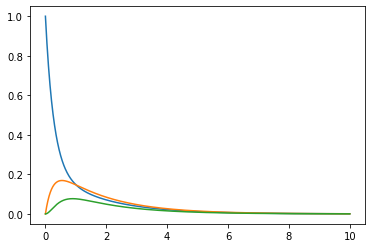

In [48]:
M = Matrix()
rho = 1.0

Pinit = np.zeros(Mdim)
Pinit[0] = 1.0

def params(t):
    return np.array([0.0001, 1.0, 2.0, 1., 1.])

def Eq(P, t):
    return dot(dot(M,params(t)),P)

times = [0.01*i for i in range(0,1001)]
sol = odeint(Eq, Pinit, times)

#print(M)
#print(dot(M,params(0)))
#print(sol)
plt.plot(times, sol[:,0])
plt.plot(times, sol[:,1])
plt.plot(times, sol[:,2])

In [156]:
statesProb = np.zeros( (Mdim,Mdim,2) )
for s in range(Mdim):
    st = states[s]
    count_a, count_b = 0, 0
    ind = []
    for i, l in enumerate(st.lng):
        count_a += l.a
        if l.a == 1:
            ind.append(i)
        count_b += l.b
    if count_a == 2 and count_b == 2 and st.lng[ ind[0] ].p == st.lng[ ind[1] ].p:
        newState_id = Coal(st, ind[0], ind[1])
        if newState_id != -1:
            statesProb[s, newState_id, st.lng[ ind[0] ].p] += 1

for i in range(Mdim):
    print(states[i].n)
    for j in range(Mdim):
        if statesProb[i, j, 0] + statesProb[i, j, 1] > 0:
            print(states[j].n, statesProb[i, j, ], " ", sep="", end="")
    
    print("\n")

110,110


110,111


111,111


100,110


100,111


101,110


101,111


010,110


010,111


011,110


011,111


010,100


010,101


011,100


011,101


010,100,110
010,110[1. 0.] 

010,100,111


011,100,110
011,110[1. 0.] 

011,100,111


010,101,110


010,101,111
010,111[0. 1.] 

011,101,110


011,101,111
011,111[0. 1.] 

010,010,100


010,011,100


011,011,100


010,010,101


010,011,101


011,011,101


010,100,100


011,100,100


010,100,101


011,100,101


010,101,101


011,101,101


010,010,100,100
010,010,100[1. 0.] 

010,011,100,100
010,011,100[1. 0.] 

011,011,100,100
011,011,100[1. 0.] 

010,010,100,101


010,011,100,101


011,011,100,101


010,010,101,101
010,010,101[0. 1.] 

010,011,101,101
010,011,101[0. 1.] 

011,011,101,101
011,011,101[0. 1.] 



In [40]:
#def params(t):
#    return np.array([0.001, 1.0, 2.0, 1., 1.])

M = Matrix()

Pinit = np.zeros(Mdim)
Pinit[0] = 1.0

T = 0.1

#times = [0.01*i for i in range(0,1001)]
sol = odeint(Eq, Pinit, [0,T])

Pinit = np.multiply(FirstCoal('a', 0), sol[1])
Pinit

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.30740284e-06])

In [35]:
FirstCoal('a', 0)

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [38]:
sol

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.01156471e-01, 5.13746852e-02, 3.23792700e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000

In [51]:
M1 = dot(M,params(0))

for i in range(Mdim):
    print(i, end=": ")
    for j in range(Mdim):
        print(M1[i, j], " ", sep="", end="")
    
    print("\n")

0: -1.202 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.002 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

1: 0.1 -0.202 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.001 0.0 0.0 0.0 0.0 0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

2: 0.0 0.2 -2.202 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.002 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

3: 0.0 0.0 0.0 -1.2009999999999998 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

4: 0.0 0.0 0.0 0.1 -0.201 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

5: 0.0 0.0 0.0 0.1 0.0 -0.201 0.1 0.0 0.0 0.0 0.0 0.0 0

In [11]:
tmp = np.array([[[0,1],[2,3]],[[-0,-1],[-2,-3]]])
np.transpose(tmp,(1,0,2))

array([[[ 0,  1],
        [ 0, -1]],

       [[ 2,  3],
        [-2, -3]]])